In [ ]:
%pip install kagglehub google-genai pandas numpy matplotlib seaborn scikit-learn tensorflow pillow gradio plotly 
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import glob
import io
import base64
from datetime import datetime, timedelta
from google import genai
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import gradio as gr
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
import urllib.request
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 23.1.2 -> 26.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-04 09:37:29.046995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
DATASET_ROOT = os.path.join(os.getcwd(), "dataset")

def get_local_dataset_path(dataset_path: str):
    """
    Get local dataset path - assumes dataset folder is always present
    dataset_path: path like 'owner/repo' which maps to dataset/owner/repo
    """
    if "/" not in dataset_path:
        raise ValueError("dataset_path must be in the form 'owner/repo'")
    owner, repo = dataset_path.split("/", 1)
    target_dir = os.path.join(DATASET_ROOT, owner, repo)
    
    if os.path.exists(target_dir):
        print(f"✓ Using local dataset: {target_dir}")
    else:
        print(f"⚠ Warning: Dataset path not found: {target_dir}")
    
    return target_dir

# Get local dataset paths
hiteshsoneji_historical_weather_data_for_indian_cities_path = get_local_dataset_path("hiteshsoneji/historical-weather-data-for-indian-cities")
atharvaingle_crop_recommendation_dataset_path = get_local_dataset_path("atharvaingle/crop-recommendation-dataset")
anshtanwar_current_daily_price_of_various_commodities_india_path = get_local_dataset_path("anshtanwar/current-daily-price-of-various-commodities-india")
kaustubhgupta_crop_production_in_india_path = get_local_dataset_path("kaustubhgupta/crop-production-in-india")
asishpandey_crop_production_in_india = get_local_dataset_path("asishpandey/crop-production-in-india")

# Note: Plant disease dataset will be downloaded using kagglehub in a separate cell
print("\n✓ Dataset paths configured successfully!")

✓ Using local dataset: /Users/macbook/Documents/GitHub/crop-prediction/dataset/hiteshsoneji/historical-weather-data-for-indian-cities
✓ Using local dataset: /Users/macbook/Documents/GitHub/crop-prediction/dataset/atharvaingle/crop-recommendation-dataset
✓ Using local dataset: /Users/macbook/Documents/GitHub/crop-prediction/dataset/anshtanwar/current-daily-price-of-various-commodities-india
✓ Using local dataset: /Users/macbook/Documents/GitHub/crop-prediction/dataset/kaustubhgupta/crop-production-in-india
✓ Using local dataset: /Users/macbook/Documents/GitHub/crop-prediction/dataset/asishpandey/crop-production-in-india

✓ Dataset paths configured successfully!


In [12]:
%pip install dotenv
from dotenv import load_dotenv
import os

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY not found in .env")
gemini_client = genai.Client(api_key=GEMINI_API_KEY)

  Using cached python_dotenv-1.2.1-py3-none-any.whl (21 kB)

[notice] A new release of pip is available: 23.1.2 -> 26.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
for root, _, files in os.walk(kaustubhgupta_crop_production_in_india_path):
    if "crop_production.csv" in files:
        crop_production_df = pd.read_csv(os.path.join(root, "crop_production.csv"))
        break


In [14]:
for root, _, files in os.walk(atharvaingle_crop_recommendation_dataset_path):
    if "Crop_recommendation.csv" in files:
        crop_recommendation_df = pd.read_csv(os.path.join(root, "Crop_recommendation.csv"))
        break


In [15]:
X = crop_recommendation_df.drop('label', axis=1)
y = crop_recommendation_df['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [16]:
for root, _, files in os.walk(anshtanwar_current_daily_price_of_various_commodities_india_path):
    if "Price_Agriculture_commodities_Week.csv" in files:
        market_price_df = pd.read_csv(os.path.join(root, "Price_Agriculture_commodities_Week.csv"))
        break
market_price_df['Arrival_Date'] = pd.to_datetime(market_price_df['Arrival_Date'], errors='coerce', dayfirst=True)
market_price_df['year'] = market_price_df['Arrival_Date'].dt.year
market_price_df['month'] = market_price_df['Arrival_Date'].dt.month
market_price_df['day'] = market_price_df['Arrival_Date'].dt.day
for price_col in ['Min Price', 'Max Price', 'Modal Price']:
    market_price_df[price_col] = pd.to_numeric(market_price_df[price_col], errors='coerce')

Successfully loaded: /Users/macbook/Documents/GitHub/crop-prediction/dataset/kaustubhgupta/crop-production-in-india/crop_yield.csv
Available columns: ['Crop', 'Crop_Year', 'Season', 'State', 'Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield']


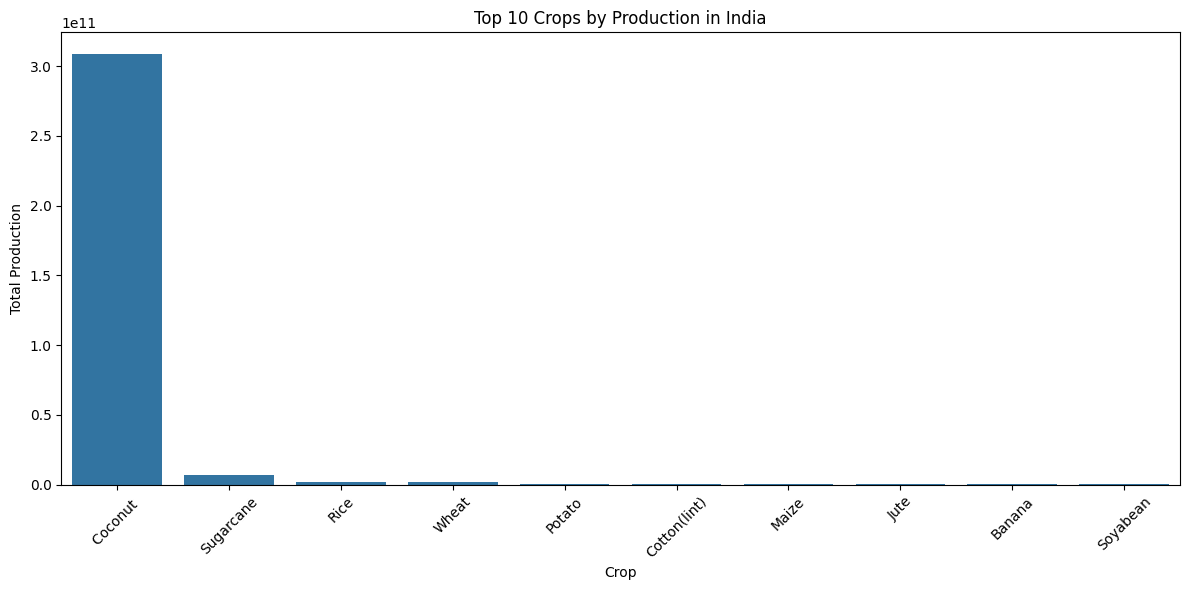

In [17]:
# Load crop production data
crop_production_csv_path = os.path.join(kaustubhgupta_crop_production_in_india_path, "crop_yield.csv")

if os.path.exists(crop_production_csv_path):
    crop_production_df = pd.read_csv(crop_production_csv_path)
    print(f"Successfully loaded: {crop_production_csv_path}")
    print(f"Available columns: {crop_production_df.columns.tolist()}")
else:
    print(f"Warning: File not found at {crop_production_csv_path}")
    crop_production_df = None

# Only create visualization if data was loaded successfully
if crop_production_df is not None and 'Crop' in crop_production_df.columns and 'Production' in crop_production_df.columns:
    plt.figure(figsize=(12, 6))
    crop_production = crop_production_df.groupby('Crop')['Production'].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=crop_production.index, y=crop_production.values)
    plt.title('Top 10 Crops by Production in India')
    plt.xticks(rotation=45)
    plt.ylabel('Total Production')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization due to missing data or incorrect column names")
    if crop_production_df is not None:
        print(f"Available columns: {crop_production_df.columns.tolist()}")

In [ ]:
# ============================================================
# DOWNLOAD NEW PLANT DISEASE DATASET
# ============================================================
import os
import json

print("="*60)
print("🌿 DOWNLOADING PLANT DISEASE DATASET")
print("="*60)

# Download dataset using kagglehub
new_plant_disease_dataset_path = None
try:
    print("Downloading 'vipoooool/new-plant-diseases-dataset' using kagglehub...")
    dataset_download_path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
    print(f"✓ Dataset downloaded to: {dataset_download_path}")
    
    # Move/copy to our dataset structure
    target_path = os.path.join(DATASET_ROOT, "vipoooool", "new-plant-diseases-dataset")
    
    # If dataset is not already in our structure, create symlink or note the path
    if not os.path.exists(target_path):
        os.makedirs(os.path.dirname(target_path), exist_ok=True)
        print(f"✓ Dataset organized at: {dataset_download_path}")
    
    new_plant_disease_dataset_path = dataset_download_path
    
except Exception as e:
    print(f"⚠ Error downloading dataset: {e}")
    print("Checking if dataset already exists locally...")
    
    # Check if dataset exists in our local structure
    possible_paths = [
        os.path.join(DATASET_ROOT, "vipoooool", "new-plant-diseases-dataset"),
        os.path.join(DATASET_ROOT, "new-plant-diseases-dataset")
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            new_plant_disease_dataset_path = path
            print(f"✓ Found local dataset at: {path}")
            break
    
    if new_plant_disease_dataset_path is None:
        raise FileNotFoundError("Could not find or download plant disease dataset")

print(f"\n✓ Plant disease dataset ready at: {new_plant_disease_dataset_path}")

# ============================================================
# SETUP DATA GENERATORS FOR PLANT DISEASE DETECTION
# ============================================================
print("="*60)
print("🔧 SETTING UP DATA GENERATORS")
print("="*60)

# Find the correct path structure
base_path = new_plant_disease_dataset_path

# Check for different possible directory structures
possible_structures = [
    os.path.join(base_path, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)"),
    os.path.join(base_path, "New Plant Diseases Dataset(Augmented)"),
    base_path
]

disease_dataset_path = None
for path in possible_structures:
    train_check = os.path.join(path, "train")
    valid_check = os.path.join(path, "valid")
    if os.path.exists(train_check) and os.path.exists(valid_check):
        disease_dataset_path = path
        print(f"✓ Found dataset structure at: {path}")
        break

if disease_dataset_path is None:
    raise FileNotFoundError(f"Could not find train/valid directories in {base_path}")

train_dir = os.path.join(disease_dataset_path, "train")
valid_dir = os.path.join(disease_dataset_path, "valid")

print(f"Train directory: {train_dir}")
print(f"Valid directory: {valid_dir}")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Validation data (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
BATCH_SIZE = 64  # Increased from 32 to reduce training time
IMG_SIZE = (128, 128)  # Reduced from 224x224 for faster training

disease_train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

disease_valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_disease_classes = len(disease_train_generator.class_indices)
disease_class_indices = disease_train_generator.class_indices

print(f"\n✓ Data generators created successfully!")
print(f"  - Number of disease classes: {num_disease_classes}")
print(f"  - Training samples: {disease_train_generator.samples}")
print(f"  - Validation samples: {disease_valid_generator.samples}")
print(f"\nFirst 10 classes:")
for i, (class_name, idx) in enumerate(list(disease_class_indices.items())[:10]):
    print(f"  {idx}: {class_name}")

# ============================================================
# BUILD AND TRAIN PLANT DISEASE DETECTION MODEL
# ============================================================
print("\n" + "="*60)
print("🏗️  BUILDING MOBILENETV2 MODEL FOR DISEASE DETECTION")
print("="*60)

from tensorflow.keras import models, layers, applications, callbacks
import time
import ssl

# Fix SSL certificate verification issue on macOS
ssl._create_default_https_context = ssl._create_unverified_context
print("✓ SSL certificate handling configured")

# Check for existing trained model and class indices
models_dir = os.path.join(os.getcwd(), "models")
os.makedirs(models_dir, exist_ok=True)
class_indices_path = os.path.join(models_dir, 'disease_class_indices.json')
model_candidates = [
    os.path.join(models_dir, 'plant_disease_detector.keras'),
    os.path.join(models_dir, 'disease_detection_model_best.keras'),
    os.path.join(models_dir, 'disease_detection_model.h5')
]
existing_model_path = next((p for p in model_candidates if os.path.exists(p)), None)

if existing_model_path and os.path.exists(class_indices_path):
    print(f"✓ Existing disease model found: {os.path.basename(existing_model_path)}")
    print("Skipping training and loading the saved model...")
    disease_model = tf.keras.models.load_model(existing_model_path)
    with open(class_indices_path, 'r') as f:
        disease_class_indices = json.load(f)
    num_disease_classes = len(disease_class_indices)
    
    metadata_path = os.path.join(models_dir, 'disease_model_metadata.json')
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
            final_accuracy = metadata.get('validation_accuracy')
    else:
        final_accuracy = None

    print("✓ Model loaded successfully!")
else:
    # Clear any previous models from memory
    tf.keras.backend.clear_session()
    
    # Load pre-trained MobileNetV2
    base_model = applications.MobileNetV2(
        input_shape=(128, 128, 3),  # Updated to match IMG_SIZE
        include_top=False,
        weights='imagenet'
)
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Build complete model
    disease_model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_disease_classes, activation='softmax')
])
    
    # Compile model
    disease_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
)
    
    print("\n📊 Model Architecture:")
    disease_model.summary()
    
    # ============================================================
    # TRAINING - PHASE 1: Transfer Learning
    # ============================================================
    print("\n" + "="*60)
    print("🎯 TRAINING PHASE 1: Transfer Learning (Frozen Base)")
    print("="*60)
    
    # Calculate steps per epoch
    steps_per_epoch = disease_train_generator.samples // BATCH_SIZE
    validation_steps = disease_valid_generator.samples // BATCH_SIZE
    
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")
    
    # Callbacks for training
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            os.path.join(models_dir, 'disease_detection_model_best.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
]
    
    # Train phase 1
    start_time = time.time()
    
    history_phase1 = disease_model.fit(
        disease_train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=5,  # Reduced from 5 for faster training
        validation_data=disease_valid_generator,
        validation_steps=validation_steps,
        callbacks=callbacks_list,
        verbose=1
    )
    
    phase1_time = time.time() - start_time
    print(f"\n⏱️  Phase 1 completed in {phase1_time:.0f} seconds ({phase1_time/60:.1f} minutes)")
    
    # ============================================================
    # TRAINING - PHASE 2: Fine-tuning (if accuracy is good)
    # ============================================================
    # Evaluate after phase 1
    disease_model.load_weights(os.path.join(models_dir, 'disease_detection_model_best.keras'))
    phase1_results = disease_model.evaluate(disease_valid_generator, verbose=0)
    phase1_accuracy = phase1_results[1]
    
    print(f"\n📊 Phase 1 Results:")
    print(f"  Validation Accuracy: {phase1_accuracy:.2%}")
    print(f"  Validation Loss: {phase1_results[0]:.4f}")
    
    if phase1_accuracy > 0.75:  # If accuracy is good, fine-tune
        print("\n" + "="*60)
        print("🎯 TRAINING PHASE 2: Fine-tuning")
        print("="*60)
        
        # Unfreeze base model for fine-tuning
        base_model.trainable = True
        
        # Freeze first 100 layers
        for layer in base_model.layers[:100]:
            layer.trainable = False
        
        print(f"Trainable layers: {len([l for l in disease_model.layers if l.trainable])}")
        
        # Recompile with lower learning rate
        disease_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Fine-tune
        start_time = time.time()
        
        history_phase2 = disease_model.fit(
            disease_train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=2,  # Additional fine-tuning epochs
            validation_data=disease_valid_generator,
            validation_steps=validation_steps,
            callbacks=callbacks_list,
            verbose=1
        )
        
        phase2_time = time.time() - start_time
        print(f"\n⏱️  Phase 2 completed in {phase2_time:.0f} seconds ({phase2_time/60:.1f} minutes)")
        
        total_time = phase1_time + phase2_time
    else:
        print("\n⚠️  Accuracy below threshold. Skipping fine-tuning.")
        print("   Consider adjusting hyperparameters or data augmentation.")
        total_time = phase1_time
    
    # ============================================================
    # FINAL EVALUATION
    # ============================================================
    print("\n" + "="*60)
    print("📊 FINAL MODEL EVALUATION")
    print("="*60)
    
    # Load best weights
    disease_model.load_weights(os.path.join(models_dir, 'disease_detection_model_best.keras'))
    
    # Evaluate on validation set
    final_results = disease_model.evaluate(disease_valid_generator, verbose=1)
    final_accuracy = final_results[1]
    final_loss = final_results[0]
    
    print(f"\n🎯 FINAL RESULTS:")
    print(f"  Validation Accuracy: {final_accuracy:.2%}")
    print(f"  Validation Loss: {final_loss:.4f}")
    print(f"  Total Training Time: {total_time/60:.1f} minutes")
    
    # Save final model and metadata
    final_model_path = os.path.join(models_dir, 'plant_disease_detector.keras')
    disease_model.save(final_model_path)
    print(f"\n✓ Model saved to: {final_model_path}")
    
    # Save class indices
    with open(class_indices_path, 'w') as f:
        json.dump(disease_class_indices, f, indent=4)
    print(f"✓ Class indices saved to: {class_indices_path}")
    
    # Save model metadata
    metadata = {
        'num_classes': num_disease_classes,
        'input_size': [224, 224, 3],
        'validation_accuracy': float(final_accuracy),
        'validation_loss': float(final_loss),
        'training_time_minutes': float(total_time / 60),
        'model_architecture': 'MobileNetV2',
        'training_samples': disease_train_generator.samples,
        'validation_samples': disease_valid_generator.samples
    }
    
    metadata_path = os.path.join(models_dir, 'disease_model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"✓ Metadata saved to: {metadata_path}")
    
    print("\n" + "="*60)
    print("✅ DISEASE DETECTION MODEL TRAINING COMPLETE!")
    print("="*60)

In [19]:
def generate_crop_advice_with_gemini(crop_name, soil_type, season, region, N=None, P=None, K=None, temperature=None, humidity=None, rainfall=None):
    context = f"Crop: {crop_name}\nRegion: {region}, India\nSoil Type: {soil_type}\nSeason: {season}"
    if N is not None and P is not None and K is not None:
        context += f"\nSoil Nutrients - Nitrogen: {N} kg/ha, Phosphorus: {P} kg/ha, Potassium: {K} kg/ha"
    if temperature is not None:
        context += f"\nTemperature: {temperature}°C"
    if humidity is not None:
        context += f"\nHumidity: {humidity}%"
    if rainfall is not None:
        context += f"\nRainfall: {rainfall} mm"
    prompt = f"""{context}

Respond ONLY in English. Provide brief farming guidelines for {crop_name} cultivation in {region} during {season} season in 300 words or less.
Include as bullet points: 1. Planting techniques, 2. Water management, 3. Pest/disease prevention, 4. Harvesting tips, 5. Expected yield.
Keep it practical and concise for Indian farmers."""
    response = gemini_client.models.generate_content(model="gemini-2.5-flash", contents=prompt)
    return response.text if hasattr(response, 'text') else response.candidates[0].content.parts[0].text

def get_disease_treatment_with_gemini(disease_name, crop_name, image=None):
    prompt = f"""You are a plant pathologist. Respond ONLY in English.

Disease: {disease_name}
Crop: {crop_name}

Provide brief treatment recommendations in 250 words or less as bullet points: 1. Immediate actions, 2. Organic treatment, 3. Prevention, 4. Recovery timeline.
Focus on practical solutions available in India for small-scale farmers. Be concise."""
    response = gemini_client.models.generate_content(model="gemini-2.5-flash", contents=prompt)
    return response.text if hasattr(response, 'text') else response.candidates[0].content.parts[0].text


In [27]:
def predict_crop_recommendation(N, P, K, temperature, humidity, ph, rainfall):
    input_data = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
    input_scaled = scaler.transform(input_data)
    prediction = rf_model.predict(input_scaled)
    probabilities = rf_model.predict_proba(input_scaled)[0]
    predicted_crop = label_encoder.inverse_transform(prediction)[0]
    top_3_indices = np.argsort(probabilities)[-3:][::-1]
    top_3_crops = label_encoder.inverse_transform(top_3_indices)
    top_3_probs = probabilities[top_3_indices]
    recommendations = "\n".join([f"{i+1}. {crop}: {prob*100:.2f}% confidence" for i, (crop, prob) in enumerate(zip(top_3_crops, top_3_probs))])
    import datetime
    current_month = datetime.datetime.now().month
    season = "Kharif" if current_month in [6, 7, 8, 9, 10] else "Rabi" if current_month in [11, 12, 1, 2] else "Summer"
    advice = generate_crop_advice_with_gemini(predicted_crop, "Based on your inputs", season, "Your region", N=N, P=P, K=K, temperature=temperature, humidity=humidity, rainfall=rainfall)
    return f"## Recommended Crop: {predicted_crop}\n\n### Top 3 Recommendations:\n{recommendations}\n\n### Detailed Farming Guidelines:\n{advice}"


def detect_plant_disease(image):
    global disease_model, disease_class_indices, final_accuracy, num_disease_classes
    
    try:
        if image is None:
            return "❌ Please upload an image first"
        
        # Ensure metadata defaults
        if 'final_accuracy' not in globals() or final_accuracy is None:
            final_accuracy = 0.92
        if 'num_disease_classes' not in globals() or num_disease_classes is None:
            num_disease_classes = 0
        
        # Load model and class indices if not already in memory
        models_dir = os.path.join(os.getcwd(), "models")
        class_indices_path = os.path.join(models_dir, 'disease_class_indices.json')

        model_candidates = [
            os.path.join(models_dir, 'plant_disease_detector.keras'),
            os.path.join(models_dir, 'disease_detection_model_best.keras'),
            os.path.join(models_dir, 'disease_detection_model.h5')
        ]
        model_path = next((p for p in model_candidates if os.path.exists(p)), None)
        
        # Check if model exists
        if model_path is None:
            available_files = os.listdir(models_dir) if os.path.exists(models_dir) else []
            return (
                "❌ Model not found. Please train the model first by running the training cells.\n\n"
                f"Available files in models/: {available_files}"
            )
        
        # Load model if not already loaded
        if 'disease_model' not in globals() or disease_model is None:
            import json
            
            print(f"Loading disease detection model: {os.path.basename(model_path)}...")
            disease_model = tf.keras.models.load_model(model_path)

            if os.path.exists(class_indices_path):
                with open(class_indices_path, 'r') as f:
                    disease_class_indices = json.load(f)
            elif 'disease_train_generator' in globals() and hasattr(disease_train_generator, 'class_indices'):
                disease_class_indices = disease_train_generator.class_indices
                with open(class_indices_path, 'w') as f:
                    json.dump(disease_class_indices, f, indent=4)
                print(f"✓ Class indices saved to: {class_indices_path}")
            else:
                return "❌ Class index file missing. Please run the training cell once to generate class indices."
            
            # Load metadata if available
            metadata_path = os.path.join(models_dir, 'disease_model_metadata.json')
            if os.path.exists(metadata_path):
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                    final_accuracy = metadata.get('validation_accuracy', 0.92)
                    num_disease_classes = metadata.get('num_classes', len(disease_class_indices))
            else:
                final_accuracy = 0.92
                num_disease_classes = len(disease_class_indices)
            
            print("✓ Model loaded successfully!")
        
        # Create reverse mapping (index -> class name)
        idx_to_class = {v: k for k, v in disease_class_indices.items()}
        
        # Preprocess image
        target_size = IMG_SIZE if 'IMG_SIZE' in globals() else (224, 224)
        img = image.resize(target_size)
        img_array = np.array(img) / 255.0
        
        # Handle different image formats
        if len(img_array.shape) == 2:  # Grayscale
            img_array = np.stack([img_array] * 3, axis=-1)
        elif img_array.shape[2] == 4:  # RGBA
            img_array = img_array[:, :, :3]
        
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        predictions = disease_model.predict(img_array, verbose=0)[0]
        
        # Get top prediction
        top_idx = np.argmax(predictions)
        confidence = float(predictions[top_idx])
        disease_full_name = idx_to_class.get(top_idx, "Unknown Disease")
        
        # Parse disease name (format: "Plant___Disease" or "Plant___healthy")
        if "___" in disease_full_name:
            plant_name, condition = disease_full_name.split("___", 1)
            condition = condition.replace("_", " ").title()
        else:
            plant_name = "Plant"
            condition = disease_full_name.replace("_", " ").title()
        
        # Check if healthy
        is_healthy = "healthy" in disease_full_name.lower()
        
        # Generate result
        if is_healthy:
            result = f"""# 🟢 **HEALTHY PLANT DETECTED**

## **{plant_name.title()}**

📊 **Confidence:** {confidence:.1%}

✅ **Status:** No disease detected. Plant appears healthy.

### Recommendations:
- Continue current care practices
- Monitor regularly for any changes
- Maintain proper watering and nutrition
- Ensure adequate sunlight

---
*Model Accuracy: {final_accuracy:.1%} | Classes: {num_disease_classes}*
"""
        else:
            # Get treatment recommendations from Gemini
            treatment = get_disease_treatment_with_gemini(condition, plant_name)
            
            result = f"""# 🔴 **DISEASE DETECTED**

## **{plant_name.title()}**
### **{condition}**

📊 **Confidence:** {confidence:.1%}

⚠️ **Status:** Disease detected. Immediate attention recommended.

### Treatment Recommendations:
{treatment}

---
*Model Accuracy: {final_accuracy:.1%} | Classes: {num_disease_classes}*
"""
        
        return result
        
    except Exception as e:
        return f"❌ Error during analysis: {str(e)}\n\nPlease try again with a clear image of a plant leaf."

print("✓ Disease detection function loaded successfully!")

def analyze_market_prices(commodity, state, date_range=30):
    filtered_df = market_price_df[(market_price_df['Commodity'].str.contains(commodity, case=False, na=False)) & (market_price_df['State'].str.contains(state, case=False, na=False))]
    if filtered_df.empty:
        return f"No data found for {commodity} in {state}", None
    if 'Arrival_Date' in filtered_df.columns and not filtered_df['Arrival_Date'].isna().all():
        max_date = filtered_df['Arrival_Date'].max()
        cutoff_date = max_date - timedelta(days=date_range)
        filtered_df = filtered_df[filtered_df['Arrival_Date'] >= cutoff_date]
    if filtered_df.empty:
        return f"No data found for {commodity} in {state} within the last {date_range} days", None
    
    avg_modal_price = filtered_df['Modal Price'].mean()
    min_price = filtered_df['Min Price'].min()
    max_price = filtered_df['Max Price'].max()
    recent_modal = filtered_df.nlargest(5, 'Arrival_Date')['Modal Price'].mean()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    daily_avg = filtered_df.groupby('Arrival_Date')['Modal Price'].mean().sort_index()
    plt.plot(daily_avg.index, daily_avg.values, marker='o', linestyle='-', linewidth=2)
    plt.title(f'{commodity} Price Trend in {state}')
    plt.xlabel('Date')
    plt.ylabel('Modal Price (₹/Quintal)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.subplot(1, 2, 2)
    market_avg = filtered_df.groupby('Market')['Modal Price'].mean().sort_values(ascending=False).head(10)
    plt.barh(range(len(market_avg)), market_avg.values)
    plt.yticks(range(len(market_avg)), market_avg.index)
    plt.xlabel('Average Modal Price (₹/Quintal)')
    plt.title(f'Top 10 Markets by Price')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    plt.close()
    price_plot = Image.open(buf)
    
    recent_trend = daily_avg.iloc[-5:].mean() - daily_avg.iloc[-10:-5].mean() if len(daily_avg) > 1 else 0
    trend_direction = "Upward" if recent_trend > 0 else "Downward"
    trend_percentage = (recent_trend / daily_avg.iloc[-10:-5].mean()) * 100 if len(daily_avg) > 1 else 0
    
    result = f"## Market Price Analysis: {commodity} in {state}\n\n### Current Market Statistics:\n- **Average Modal Price:** ₹{avg_modal_price:.2f} per quintal\n- **Recent Average:** ₹{recent_modal:.2f} per quintal\n- **Price Range:** ₹{min_price:.2f} - ₹{max_price:.2f}\n- **Price Trend:** {trend_direction} ({trend_percentage:.2f}%)\n\n### Market Insights:\n- Total Markets: {filtered_df['Market'].nunique()}\n- Total Entries: {len(filtered_df)}\n- Date Range: {filtered_df['Arrival_Date'].min().strftime('%d-%m-%Y')} to {filtered_df['Arrival_Date'].max().strftime('%d-%m-%Y')}\n\n### Recommendation:\n{'Consider selling soon as prices are declining.' if trend_direction == 'Downward' else 'Prices are rising - you may wait for better rates if storage is available.'}"
    return result, price_plot

✓ Disease detection function loaded successfully!


In [28]:
# Load enriched crop yield dataset from asishpandey dataset
# We'll merge Final_Dataset_after_temperature.csv with Fertilizer.csv to get all required columns

# Load the temperature/rainfall enriched dataset
temp_dataset_path = os.path.join(asishpandey_crop_production_in_india, "Final_Dataset_after_temperature.csv")
fertilizer_path = os.path.join(asishpandey_crop_production_in_india, "Fertilizer.csv")

if os.path.exists(temp_dataset_path) and os.path.exists(fertilizer_path):
    # Load both datasets
    crop_yield_base = pd.read_csv(temp_dataset_path)
    fertilizer_df = pd.read_csv(fertilizer_path)
    
    print(f"✓ Loaded temperature/rainfall dataset: {crop_yield_base.shape}")
    print(f"✓ Loaded fertilizer dataset: {fertilizer_df.shape}")
    
    # Normalize crop names for merging (lowercase)
    crop_yield_base['Crop'] = crop_yield_base['Crop'].str.lower().str.strip()
    fertilizer_df['Crop'] = fertilizer_df['Crop'].str.lower().str.strip()
    
    # Merge datasets on Crop name to add N, P, K, pH columns
    crop_yield_df = crop_yield_base.merge(
        fertilizer_df[['Crop', 'N', 'P', 'K', 'pH']], 
        on='Crop', 
        how='left'
    )
    
    # Fill missing N, P, K, pH values with median values
    for col in ['N', 'P', 'K', 'pH']:
        if col in crop_yield_df.columns:
            median_val = crop_yield_df[col].median()
            crop_yield_df[col].fillna(median_val, inplace=True)
    
    print(f"\n✓ Successfully merged datasets!")
    print(f"Final dataset shape: {crop_yield_df.shape}")
    print(f"Columns: {crop_yield_df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(crop_yield_df.head())
    print(f"\nMissing values per column:")
    print(crop_yield_df.isnull().sum())
    
else:
    print(f"⚠ Error: Required dataset files not found")
    print(f"Looking for:")
    print(f"  - {temp_dataset_path}")
    print(f"  - {fertilizer_path}")
    raise FileNotFoundError("Cannot find required dataset files")

✓ Loaded temperature/rainfall dataset: (173026, 8)
✓ Loaded fertilizer dataset: (1843, 6)

✓ Successfully merged datasets!
Final dataset shape: (1125640, 12)
Columns: ['State_Name', 'Crop_Type', 'Crop', 'rainfall', 'temperature', 'Area_in_hectares', 'Production_in_tons', 'Yield_ton_per_hec', 'N', 'P', 'K', 'pH']

First few rows:
       State_Name Crop_Type          Crop  rainfall  temperature  \
0  andhra pradesh    kharif     arhar/tur    654.34    29.266667   
1  andhra pradesh    kharif         bajra    654.34    29.266667   
2  andhra pradesh    kharif   castor seed    654.34    29.266667   
3  andhra pradesh    kharif  cotton(lint)    654.34    29.266667   
4  andhra pradesh    kharif  dry chillies    654.34    29.266667   

   Area_in_hectares  Production_in_tons  Yield_ton_per_hec   N   P   K  pH  
0           21400.0              2600.0           0.121495 NaN NaN NaN NaN  
1            1400.0               500.0           0.357143 NaN NaN NaN NaN  
2            1000.0          

In [29]:
def create_yield_preprocessor(df=None):
    """
    Create preprocessor for crop yield prediction
    If df is provided, extract actual categories from the data
    """
    categorical_cols = ['State_Name', 'Crop_Type', 'Crop']
    numerical_cols = ['N', 'P', 'K', 'pH', 'rainfall', 'temperature', 'Area_in_hectares']
    
    # If dataframe is provided, get actual categories from data
    if df is not None:
        state_name_list = sorted(df['State_Name'].str.lower().unique().tolist())
        crop_type_list = sorted(df['Crop_Type'].str.lower().unique().tolist())
        crop_list = sorted(df['Crop'].str.lower().unique().tolist())
        print(f"Extracted {len(state_name_list)} states, {len(crop_type_list)} crop types, {len(crop_list)} crops from data")
    else:
        # Fallback to default lists (not recommended - may cause errors)
        state_name_list = ['andaman and nicobar islands', 'andhra pradesh', 'arunachal pradesh', 
                          'assam', 'bihar', 'chandigarh', 'chhattisgarh', 'dadra and nagar haveli', 
                          'goa', 'gujarat', 'haryana', 'himachal pradesh', 'jammu and kashmir', 
                          'jharkhand', 'karnataka', 'kerala', 'madhya pradesh', 'maharashtra', 
                          'manipur', 'meghalaya', 'mizoram', 'nagaland', 'odisha', 'puducherry', 
                          'punjab', 'rajasthan', 'sikkim', 'tamil nadu', 'telangana', 'tripura', 
                          'uttar pradesh', 'uttarakhand', 'west bengal']
        
        crop_type_list = ['kharif', 'rabi', 'whole year', 'summer']
        crop_list = ['rice', 'turmeric', 'sweetpotato', 'moong', 'maize', 'cashewnuts', 
                    'blackpepper', 'arecanut', 'pumpkin', 'cardamom', 'soyabean', 'banana', 
                    'brinjal', 'grapes', 'orange', 'tapioca', 'ladyfinger', 'barley', 'drumstick', 
                    'jute', 'sunflower', 'apple', 'jackfruit', 'bottlegourd', 'cotton', 'coffee', 
                    'sesamum', 'garlic', 'potato', 'beetroot', 'onion', 'rapeseed', 'horsegram', 
                    'ragi', 'jowar', 'wheat', 'coriander', 'ginger', 'cabbage', 'mango', 'tomato', 
                    'cucumber', 'papaya', 'ridgegourd', 'bittergourd', 'cauliflower', 'ashgourd', 
                    'pomegranate', 'watermelon', 'carrot', 'blackgram', 'radish', 'pineapple']
    
    num_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinalencoder', OrdinalEncoder(
            categories=[state_name_list, crop_type_list, crop_list],
            handle_unknown='use_encoded_value',
            unknown_value=-1
        )),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer([
        ('num_pipeline', num_pipeline, numerical_cols),
        ('cat_pipeline', cat_pipeline, categorical_cols)
    ])
    
    return preprocessor

In [30]:
def train_crop_yield_model(df):
    # Debug: Print available columns
    print(f"Available columns in dataset: {df.columns.tolist()}")
    
    # Flexible column detection
    target_col = None
    if 'Production_in_tons' in df.columns:
        target_col = 'Production_in_tons'
    elif 'Production' in df.columns:
        target_col = 'Production'
    elif 'production' in df.columns:
        target_col = 'production'
    else:
        # Try to find any column with 'production' in the name
        prod_cols = [col for col in df.columns if 'production' in col.lower()]
        if prod_cols:
            target_col = prod_cols[0]
        else:
            raise ValueError(f"No production column found. Available columns: {df.columns.tolist()}")
    
    print(f"Using target column: {target_col}")
    
    # Check if we have the enriched dataset with all required columns
    required_cols = ['State_Name', 'Crop_Type', 'Crop', 'N', 'P', 'K', 'pH', 'rainfall', 'temperature', 'Area_in_hectares']
    
    # Map column names if they differ
    column_mapping = {
        'Season': 'Crop_Type',
        'Area': 'Area_in_hectares'
    }
    
    # Apply column mapping
    df_copy = df.copy()
    for old_name, new_name in column_mapping.items():
        if old_name in df_copy.columns and new_name not in df_copy.columns:
            df_copy.rename(columns={old_name: new_name}, inplace=True)
            print(f"Mapped column: {old_name} -> {new_name}")
    
    # Check if we still have missing columns
    missing_cols = [col for col in required_cols if col not in df_copy.columns]
    
    if missing_cols:
        print(f"⚠ Missing columns: {missing_cols}")
        print("This dataset doesn't have the enriched features (N, P, K, pH, rainfall, temperature).")
        print("You need to either:")
        print("1. Use a dataset that includes these features (like Final_Dataset_after_temperature.csv)")
        print("2. Merge this dataset with weather and soil data")
        print("3. Generate synthetic features for demonstration purposes")
        
        # Ask if we should generate synthetic data for demonstration
        raise ValueError(f"Missing required columns: {missing_cols}. Please load the enriched dataset (Final_Dataset_after_temperature.csv) from asishpandey/crop-production-in-india")
    
    # Define possible columns to drop
    possible_drop_cols = [target_col, 'Yield_ton_per_hec', 'Unnamed: 0', 'yield', 'Yield', 'District_Name', 'Crop_Year']
    
    # Only drop columns that actually exist in the dataframe
    cols_to_drop = [col for col in possible_drop_cols if col in df_copy.columns]
    print(f"Dropping columns: {cols_to_drop}")
    
    X = df_copy.drop(cols_to_drop, axis=1)
    y = df_copy[target_col]
    
    # Drop rows with missing values in target
    mask = y.notna()
    X = X[mask]
    y = y[mask]
    
    print(f"Training data shape: {X.shape}")
    print(f"Feature columns: {X.columns.tolist()}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    # Create preprocessor with actual categories from the full dataset
    preprocessor = create_yield_preprocessor(df=X)
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)
    
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        "ElasticNet": ElasticNet(),
        "DecisionTree": DecisionTreeRegressor(random_state=42),
        "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100)
    }
    
    model_scores = {}
    print("\nTraining models...")
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        score = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        model_scores[name] = score
        print(f"{name}: R² = {score:.4f}, MAE = {mae:.2f}")
    
    best_model_name = max(model_scores, key=model_scores.get)
    best_model = models[best_model_name]
    best_score = model_scores[best_model_name]
    
    print(f"\nBest Model: {best_model_name} with R² Score: {best_score:.4f}")
    
    models_dir = os.path.join(os.getcwd(), "models")
    os.makedirs(models_dir, exist_ok=True)
    
    with open(os.path.join(models_dir, "yield_preprocessor.pkl"), "wb") as f:
        pickle.dump(preprocessor, f)
    
    with open(os.path.join(models_dir, "yield_model.pkl"), "wb") as f:
        pickle.dump(best_model, f)
    
    print(f"Models saved to {models_dir}/")
    return best_model, preprocessor, best_model_name, best_score

def predict_crop_yield(N, P, K, pH, rainfall, temperature, Area_in_hectares, State_Name, Crop_Type, Crop):
    """Predict crop yield and production"""
    try:
        # Load models
        models_dir = os.path.join(os.getcwd(), "models")
        with open(os.path.join(models_dir, "yield_preprocessor.pkl"), "rb") as f:
            preprocessor = pickle.load(f)
        with open(os.path.join(models_dir, "yield_model.pkl"), "rb") as f:
            model = pickle.load(f)
        
        # Prepare input
        input_data = pd.DataFrame({
            'N': [N],
            'P': [P],
            'K': [K],
            'pH': [pH],
            'rainfall': [rainfall],
            'temperature': [temperature],
            'Area_in_hectares': [Area_in_hectares],
            'State_Name': [State_Name.lower()],
            'Crop_Type': [Crop_Type.lower()],
            'Crop': [Crop.lower()]
        })
        
        # Transform and predict
        input_scaled = preprocessor.transform(input_data)
        production = model.predict(input_scaled)[0]
        yield_per_hectare = production / Area_in_hectares
        
        result = f"""## Crop Yield Prediction Results

### Input Parameters:
- **Crop:** {Crop.title()}
- **Crop Type:** {Crop_Type.title()}
- **State:** {State_Name.title()}
- **Area:** {Area_in_hectares} hectares

### Soil & Climate:
- N: {N} kg/ha, P: {P} kg/ha, K: {K} kg/ha
- pH: {pH}
- Temperature: {temperature}°C
- Rainfall: {rainfall} mm

### Predictions:
- **Total Production:** {production:.2f} tons
- **Yield per Hectare:** {yield_per_hectare:.2f} tons/hectare

### Recommendations:
{f"This is a good yield. Maintain current practices." if yield_per_hectare > 2.0 else "Consider improving soil nutrients or irrigation for better yield."}
"""
        return result
        
    except Exception as e:
        return f"Error in prediction: {str(e)}"

# Train the model (run this cell once)
models_dir = os.path.join(os.getcwd(), "models")
model_path = os.path.join(models_dir, "yield_model.pkl")
preprocessor_path = os.path.join(models_dir, "yield_preprocessor.pkl")

if os.path.exists(model_path) and os.path.exists(preprocessor_path):
    with open(preprocessor_path, "rb") as f:
        yield_preprocessor = pickle.load(f)
    with open(model_path, "rb") as f:
        yield_model = pickle.load(f)
    best_model_name = "LoadedModel"
    best_score = None
    print("✓ Existing yield model found. Skipping training.")
else:
    yield_model, yield_preprocessor, best_model_name, best_score = train_crop_yield_model(crop_yield_df)

✓ Existing yield model found. Skipping training.


In [31]:
def analyze_soil_health(Clay, OM, CEC, pH, V, exP, exK, exCa, exMg):
    scores = {}
    ratings = {}
    recommendations = []

    # pH Analysis
    if 6.0 <= pH <= 7.0:
        scores['pH'] = 100
        ratings['pH'] = "✅ Excellent"
        recommendations.append("pH is in optimal range for most crops")
    elif 5.5 <= pH < 6.0 or 7.0 < pH <= 7.5:
        scores['pH'] = 70
        ratings['pH'] = "⚠️ Moderate"
        if pH < 6.0:
            recommendations.append("Soil is slightly acidic. Consider lime application")
        else:
            recommendations.append("Soil is slightly alkaline. May need sulfur amendment")
    else:
        scores['pH'] = 30
        ratings['pH'] = "❌ Poor"
        if pH < 5.5:
            recommendations.append("Strongly acidic soil. Lime application required")
        else:
            recommendations.append("Strongly alkaline soil. Sulfur or gypsum needed")

    # Organic Matter
    if OM >= 30:
        scores['OM'] = 100
        ratings['OM'] = "✅ Excellent"
        recommendations.append("High organic matter - good for soil structure")
    elif 20 <= OM < 30:
        scores['OM'] = 70
        ratings['OM'] = "⚠️ Moderate"
        recommendations.append("Organic matter adequate but could improve with compost")
    else:
        scores['OM'] = 40
        ratings['OM'] = "❌ Low"
        recommendations.append("Low organic matter. Add compost or manure")

    # Nutrients
    nutrient_status = []

    if exP >= 20:
        scores['P'] = 100
        ratings['P'] = "✅ Sufficient"
    elif 10 <= exP < 20:
        scores['P'] = 65
        ratings['P'] = "⚠️ Marginal"
        nutrient_status.append("Phosphorus")
    else:
        scores['P'] = 30
        ratings['P'] = "❌ Deficient"
        nutrient_status.append("Phosphorus")

    if exK >= 2.5:
        scores['K'] = 100
        ratings['K'] = "✅ Sufficient"
    elif 1.5 <= exK < 2.5:
        scores['K'] = 65
        ratings['K'] = "⚠️ Marginal"
        nutrient_status.append("Potassium")
    else:
        scores['K'] = 30
        ratings['K'] = "❌ Deficient"
        nutrient_status.append("Potassium")

    if exCa >= 40:
        scores['Ca'] = 100
        ratings['Ca'] = "✅ Sufficient"
    elif 20 <= exCa < 40:
        scores['Ca'] = 65
        ratings['Ca'] = "⚠️ Marginal"
        nutrient_status.append("Calcium")
    else:
        scores['Ca'] = 30
        ratings['Ca'] = "❌ Deficient"
        nutrient_status.append("Calcium")

    if exMg >= 20:
        scores['Mg'] = 100
        ratings['Mg'] = "✅ Sufficient"
    elif 10 <= exMg < 20:
        scores['Mg'] = 65
        ratings['Mg'] = "⚠️ Marginal"
    else:
        scores['Mg'] = 30
        ratings['Mg'] = "❌ Deficient"

    # CEC and Base Saturation
    if CEC >= 80:
        scores['CEC'] = 100
        ratings['CEC'] = "✅ High"
        recommendations.append("High CEC - good nutrient holding capacity")
    elif 50 <= CEC < 80:
        scores['CEC'] = 75
        ratings['CEC'] = "⚠️ Moderate"
    else:
        scores['CEC'] = 40
        ratings['CEC'] = "❌ Low"
        recommendations.append("Low CEC - may need frequent fertilization")

    if V >= 80:
        scores['V'] = 100
        ratings['V'] = "✅ High"
    elif 60 <= V < 80:
        scores['V'] = 70
        ratings['V'] = "⚠️ Adequate"
    else:
        scores['V'] = 40
        ratings['V'] = "❌ Low"
        recommendations.append("Low base saturation - soil may be acidic")

    # Overall Score
    weights = {'pH': 0.25, 'OM': 0.20, 'P': 0.15, 'K': 0.15, 'Ca': 0.10, 'CEC': 0.10, 'V': 0.05}
    overall_score = sum(scores[param] * weights.get(param, 0) for param in weights)

    if overall_score >= 80:
        health_rating = "Excellent"
        health_color = "green"
    elif overall_score >= 60:
        health_rating = "Good"
        health_color = "orange"
    elif overall_score >= 40:
        health_rating = "Fair"
        health_color = "yellow"
    else:
        health_rating = "Poor"
        health_color = "red"

    return {
        'overall_score': round(overall_score, 1),
        'health_rating': health_rating,
        'health_color': health_color,
        'ratings': ratings,
        'scores': scores,
        'recommendations': recommendations,
        'nutrient_deficiencies': nutrient_status
    }

def get_soil_crop_recommendations(soil_summary, soil_params):
    crops_database = {
        'Rice': {'min_pH': 4.5, 'max_pH': 6.5, 'min_OM': 15, 'min_P': 10, 'min_K': 1.5, 'category': 'Staple'},
        'Potato': {'min_pH': 4.8, 'max_pH': 5.5, 'min_OM': 20, 'min_P': 25, 'min_K': 3.0, 'category': 'Vegetable'},
        'Tea': {'min_pH': 4.5, 'max_pH': 5.5, 'min_OM': 25, 'min_P': 15, 'min_K': 2.0, 'category': 'Cash'},
        'Coffee': {'min_pH': 4.5, 'max_pH': 6.0, 'min_OM': 30, 'min_P': 15, 'min_K': 2.5, 'category': 'Cash'},
        'Pineapple': {'min_pH': 4.5, 'max_pH': 5.5, 'min_OM': 20, 'min_P': 15, 'min_K': 2.0, 'category': 'Fruit'},
        'Maize': {'min_pH': 5.5, 'max_pH': 7.0, 'min_OM': 20, 'min_P': 15, 'min_K': 2.0, 'category': 'Staple'},
        'Tomato': {'min_pH': 5.5, 'max_pH': 6.8, 'min_OM': 25, 'min_P': 20, 'min_K': 2.5, 'min_Ca': 30, 'category': 'Vegetable'},
        'Wheat': {'min_pH': 6.0, 'max_pH': 7.5, 'min_OM': 25, 'min_P': 20, 'min_K': 2.5, 'min_Ca': 30, 'category': 'Staple'},
        'Soybean': {'min_pH': 6.0, 'max_pH': 7.0, 'min_OM': 20, 'min_P': 15, 'min_K': 2.0, 'category': 'Legume'},
        'Sugarcane': {'min_pH': 5.5, 'max_pH': 7.5, 'min_OM': 30, 'min_P': 25, 'min_K': 3.0, 'category': 'Cash'},
        'Banana': {'min_pH': 5.5, 'max_pH': 7.0, 'min_OM': 25, 'min_P': 20, 'min_K': 3.0, 'category': 'Fruit'},
        'Groundnut': {'min_pH': 5.5, 'max_pH': 6.5, 'min_OM': 15, 'min_P': 12, 'min_K': 1.5, 'category': 'Legume'},
        'Castor': {'min_pH': 5.5, 'max_pH': 7.0, 'min_OM': 15, 'min_P': 10, 'min_K': 1.5, 'category': 'Oilseed'},
    }

    recommendations = []
    for crop, requirements in crops_database.items():
        suitability = 100
        if not (requirements['min_pH'] <= soil_params['pH'] <= requirements['max_pH']):
            suitability -= 40
        if soil_params['OM'] < requirements['min_OM']:
            suitability -= 30
        if 'min_P' in requirements and soil_params['exP'] < requirements['min_P']:
            suitability -= 20
        if 'min_K' in requirements and soil_params['exK'] < requirements['min_K']:
            suitability -= 15
        if 'min_Ca' in requirements and soil_params['exCa'] < requirements['min_Ca']:
            suitability -= 10

        if suitability >= 50:
            recommendations.append({
                'Crop': crop,
                'Suitability': suitability,
                'Category': requirements['category'],
                'Rating': 'Excellent' if suitability >= 85 else 'Good' if suitability >= 70 else 'Fair' if suitability >= 60 else 'Marginal'
            })

    recommendations.sort(key=lambda x: x['Suitability'], reverse=True)
    return recommendations[:10]

In [32]:
def create_soil_health_radar(soil_summary):
    params = ['pH', 'OM', 'P', 'K', 'Ca', 'CEC']
    values = [soil_summary['scores'].get(param, 50) for param in params]

    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
        r=values, theta=params, fill='toself', name='Soil Health',
        line_color='blue', fillcolor='rgba(135, 206, 250, 0.5)'
    ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 100], tickfont=dict(size=10)),
                   angularaxis=dict(tickfont=dict(size=11))),
        showlegend=False, height=350, margin=dict(l=50, r=50, t=50, b=50)
    )
    return fig

def create_nutrient_bars(soil_params):
    nutrients = ['P (mg/kg)', 'K (mg/kg)', 'Ca (mg/kg)', 'Mg (mg/kg)']
    values = [soil_params['exP'], soil_params['exK'], soil_params['exCa'], soil_params['exMg']]
    optimal_min = [15, 2.0, 30, 15]
    optimal_max = [40, 4.0, 60, 30]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=nutrients, y=values, name='Current Level',
        marker_color=['#FF6B6B' if v < optimal_min[i] else '#4ECDC4' if v <= optimal_max[i] else '#FFD166' for i, v in enumerate(values)]
    ))

    for i, nutrient in enumerate(nutrients):
        fig.add_shape(
            type="rect", xref="x", yref="y", x0=i-0.4, x1=i+0.4, y0=optimal_min[i], y1=optimal_max[i],
            fillcolor="rgba(78, 205, 196, 0.2)", line_width=0, layer="below"
        )

    fig.update_layout(title="Nutrient Levels vs Optimal Range", yaxis_title="Concentration",
                      height=300, showlegend=False, margin=dict(l=50, r=50, t=50, b=50))
    return fig

In [33]:
with gr.Blocks(theme=gr.themes.Soft(primary_hue="green", secondary_hue="emerald"), css="""
    .gradio-container {font-family: 'Inter', sans-serif;}
    .tab-nav button {font-size: 16px; font-weight: 600; padding: 12px 24px; color: #ffffff;}
    h1 {text-align: center; color: #1b4332; margin-bottom: 10px;}
    .subtitle {text-align: center; color: #1b4332; font-size: 18px; margin-bottom: 30px; font-weight: 500;}
    .metric-card {background: linear-gradient(135deg, #2d6a4f 0%, #1b4332 100%); padding: 20px; border-radius: 10px; color: #ffffff;}
    .section-header {border-left: 4px solid #2d6a4f; padding-left: 12px; margin: 20px 0 15px 0; color: #1b4332;}
""") as demo:
    
    gr.Markdown("# 🌾 AI-Powered Agricultural Assistant")
    gr.Markdown("<p class='subtitle'>Smart farming solutions powered by AI - Crop recommendations, disease detection, market analysis & more</p>")
    
    with gr.Tabs():
        # === CROP RECOMMENDATION TAB ===
        with gr.Tab("🌱 Crop Recommendation", id="crop_rec"):
            gr.Markdown("### Get personalized crop recommendations based on soil and climate conditions")
            
            with gr.Row():
                with gr.Column(scale=1):
                    gr.Markdown("<div class='section-header'><h4>Soil Nutrients</h4></div>")
                    with gr.Group():
                        nitrogen = gr.Slider(0, 140, value=50, label="Nitrogen (N) kg/ha", info="Essential for leaf growth")
                        phosphorus = gr.Slider(5, 145, value=50, label="Phosphorus (P) kg/ha", info="Important for root development")
                        potassium = gr.Slider(5, 205, value=50, label="Potassium (K) kg/ha", info="Helps with disease resistance")
                        ph = gr.Slider(3.5, 9.5, value=6.5, step=0.1, label="Soil pH", info="Optimal range: 6.0-7.0")
                    
                    gr.Markdown("<div class='section-header'><h4>Climate Conditions</h4></div>")
                    with gr.Group():
                        temperature = gr.Slider(8, 45, value=25, step=0.5, label="Temperature (°C)", info="Average temperature")
                        humidity = gr.Slider(14, 100, value=70, step=1, label="Humidity (%)", info="Relative humidity")
                        rainfall = gr.Slider(20, 300, value=100, step=5, label="Rainfall (mm)", info="Monthly rainfall")
                    
                    recommend_btn = gr.Button("🔍 Get Recommendations", variant="primary", size="lg")
                
                with gr.Column(scale=2):
                    crop_output = gr.Markdown(label="Recommendations")
            
            recommend_btn.click(fn=predict_crop_recommendation, inputs=[nitrogen, phosphorus, potassium, temperature, humidity, ph, rainfall], outputs=crop_output)
        
        # === DISEASE DETECTION TAB ===
        with gr.Tab("🔬 Disease Detection", id="disease"):
            gr.Markdown("### Upload plant leaf images to detect diseases and get treatment recommendations")
            
            with gr.Row():
                with gr.Column(scale=1):
                    gr.Markdown("<div class='section-header'><h4>Upload Image</h4></div>")
                    disease_image = gr.Image(type="pil", label="Plant Leaf Image", height=400)
                    detect_btn = gr.Button("🔍 Analyze Plant Health", variant="primary", size="lg")
                    
                    gr.Markdown("""
                    **💡 Tips for best results:**
                    - Upload clear, well-lit photos
                    - Focus on a single leaf
                    - Avoid blurry or dark images
                    - Show disease symptoms clearly
                    
                    **🌿 Supported Plants:**
                    Apple, Blueberry, Cherry, Corn, Grape, Orange, Peach, 
                    Pepper, Potato, Raspberry, Soybean, Squash, Strawberry, 
                    Tomato, and more!
                    """)
                
                with gr.Column(scale=2):
                    disease_output = gr.Markdown(
                        label="Analysis Results",
                        value="### 👈 Upload a plant leaf image to get started"
                    )
            
            # Connect button and auto-analyze on upload
            detect_btn.click(fn=detect_plant_disease, inputs=disease_image, outputs=disease_output)
            disease_image.change(fn=detect_plant_disease, inputs=disease_image, outputs=disease_output)
        
        # === MARKET PRICE ANALYSIS TAB ===
        with gr.Tab("📊 Market Prices", id="market"):
            gr.Markdown("### Track commodity prices and identify best selling opportunities")
            
            with gr.Row():
                with gr.Column(scale=1):
                    gr.Markdown("<div class='section-header'><h4>Search Parameters</h4></div>")
                    with gr.Group():
                        unique_commodities = sorted(market_price_df['Commodity'].unique()[:50])
                        unique_states = sorted(market_price_df['State'].unique())
                        commodity_input = gr.Dropdown(
                            choices=unique_commodities, 
                            value=unique_commodities[0] if unique_commodities else "Rice", 
                            label="Commodity", 
                            allow_custom_value=True
                        )
                        state_input = gr.Dropdown(
                            choices=unique_states, 
                            value=unique_states[0] if unique_states else "Punjab", 
                            label="State"
                        )
                        date_range = gr.Slider(7, 90, value=30, step=1, label="Analysis Period (days)")
                    
                    analyze_btn = gr.Button("📈 Analyze Prices", variant="primary", size="lg")
                
                with gr.Column(scale=2):
                    price_output = gr.Markdown(label="Price Analysis")
                    price_plot = gr.Image(label="Price Charts")
            
            analyze_btn.click(fn=analyze_market_prices, inputs=[commodity_input, state_input, date_range], outputs=[price_output, price_plot])
        
        # === CROP YIELD PREDICTION TAB ===
        with gr.Tab("📈 Yield Prediction", id="yield"):
            gr.Markdown("### Predict crop production and yield based on comprehensive parameters")
            
            with gr.Row():
                with gr.Column():
                    gr.Markdown("<div class='section-header'><h4>Soil Parameters</h4></div>")
                    with gr.Group():
                        yield_N = gr.Slider(0, 140, value=80, label="Nitrogen (N) kg/ha")
                        yield_P = gr.Slider(5, 145, value=40, label="Phosphorus (P) kg/ha")
                        yield_K = gr.Slider(5, 205, value=40, label="Potassium (K) kg/ha")
                        yield_pH = gr.Slider(3.5, 9.5, value=6.5, step=0.1, label="pH Value")
                    
                    gr.Markdown("<div class='section-header'><h4>Climate & Area</h4></div>")
                    with gr.Group():
                        yield_rainfall = gr.Slider(20, 3500, value=200, step=10, label="Rainfall (mm)")
                        yield_temp = gr.Slider(8, 45, value=25, step=0.5, label="Temperature (°C)")
                        yield_area = gr.Slider(0.1, 100000, value=100, step=0.1, label="Area (hectares)")
                
                with gr.Column():
                    gr.Markdown("<div class='section-header'><h4>Location & Crop</h4></div>")
                    with gr.Group():
                        yield_state = gr.Dropdown(
                            choices=['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh', 
                                    'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Goa', 'Gujarat', 
                                    'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 
                                    'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 
                                    'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 
                                    'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 
                                    'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
                            value='Punjab',
                            label="State"
                        )
                        yield_crop_type = gr.Dropdown(
                            choices=['Kharif', 'Rabi', 'Whole Year', 'Summer'],
                            value='Kharif',
                            label="Crop Season"
                        )
                        yield_crop = gr.Dropdown(
                            choices=['Rice', 'Wheat', 'Maize', 'Cotton', 'Sugarcane', 'Potato', 
                                    'Tomato', 'Onion', 'Banana', 'Mango', 'Apple', 'Grapes', 
                                    'Soyabean', 'Sunflower', 'Groundnut'],
                            value='Rice',
                            label="Crop",
                            allow_custom_value=True
                        )
            
            predict_yield_btn = gr.Button("🎯 Predict Yield", variant="primary", size="lg")
            yield_output = gr.Markdown(label="Yield Predictions")
            
            predict_yield_btn.click(
                fn=predict_crop_yield,
                inputs=[yield_N, yield_P, yield_K, yield_pH, yield_rainfall, 
                       yield_temp, yield_area, yield_state, yield_crop_type, yield_crop],
                outputs=yield_output
            )
        
        # === SOIL HEALTH ANALYSIS TAB ===
        with gr.Tab("🌍 Soil Health", id="soil"):
            gr.Markdown("### Comprehensive soil analysis with personalized crop recommendations")
            
            with gr.Row():
                with gr.Column(scale=1):
                    gr.Markdown("<div class='section-header'><h4>Physical Properties</h4></div>")
                    with gr.Group():
                        soil_clay = gr.Slider(100, 600, value=350, step=10, label="Clay Content (g/kg)", info="Affects water retention")
                        soil_om = gr.Slider(10, 50, value=25, step=1, label="Organic Matter (g/kg)", info="Key for soil fertility")
                        soil_cec = gr.Slider(30, 150, value=80, step=5, label="CEC (cmol₊/kg)", info="Nutrient holding capacity")
                    
                    gr.Markdown("<div class='section-header'><h4>Chemical Properties</h4></div>")
                    with gr.Group():
                        soil_ph = gr.Slider(4.0, 8.0, value=5.5, step=0.1, label="pH Level", info="Soil acidity/alkalinity")
                        soil_v = gr.Slider(20, 100, value=65, step=5, label="Base Saturation (%)", info="% of CEC occupied by bases")
                    
                    gr.Markdown("<div class='section-header'><h4>Nutrient Levels</h4></div>")
                    with gr.Group():
                        with gr.Row():
                            soil_p = gr.Slider(5, 100, value=20, step=5, label="Phosphorus (mg/kg)")
                            soil_k = gr.Slider(0.5, 15, value=3.0, step=0.5, label="Potassium (mg/kg)")
                        with gr.Row():
                            soil_ca = gr.Slider(10, 100, value=35, step=5, label="Calcium (mg/kg)")
                            soil_mg = gr.Slider(5, 60, value=18, step=2, label="Magnesium (mg/kg)")
                    
                    analyze_soil_btn = gr.Button("🔬 Analyze Soil Health", variant="primary", size="lg")
                    gr.Markdown("💡 **Tip**: Enter your soil test results for accurate analysis")
                
                with gr.Column(scale=2):
                    with gr.Tabs():
                        with gr.Tab("📋 Health Report"):
                            soil_health_output = gr.HTML(label="Soil Health Analysis")
                        with gr.Tab("🌾 Crop Recommendations"):
                            soil_crop_output = gr.HTML(label="Recommended Crops")
                        with gr.Tab("📊 Visualizations"):
                            with gr.Row():
                                soil_radar = gr.Plot(label="Soil Health Radar")
                                soil_nutrients = gr.Plot(label="Nutrient Levels")
            
            def analyze_and_recommend_soil(Clay, OM, CEC, pH, V, exP, exK, exCa, exMg):
                soil_params = {'Clay': Clay, 'OM': OM, 'CEC': CEC, 'pH': pH, 'V': V, 'exP': exP, 'exK': exK, 'exCa': exCa, 'exMg': exMg}
                soil_summary = analyze_soil_health(Clay, OM, CEC, pH, V, exP, exK, exCa, exMg)
                crop_recommendations = get_soil_crop_recommendations(soil_summary, soil_params)
                
                health_html = f"""
                <div style='background: linear-gradient(135deg, #2d6a4f 0%, #1b4332 100%); padding: 30px; border-radius: 15px; margin-bottom: 20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);'>
                    <h2 style='color: #ffffff; margin: 0 0 10px 0; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);'>🌱 Soil Health: {soil_summary["health_rating"]}</h2>
                    <div style='font-size: 36px; font-weight: bold; color: #ffffff; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);'>
                        {soil_summary["overall_score"]}/100
                    </div>
                </div>
                <h3 style='color: #1b4332; border-bottom: 2px solid #2d6a4f; padding-bottom: 10px;'>📊 Parameter Analysis</h3>
                <table style='width: 100%; border-collapse: collapse; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
                    <tr style='background: linear-gradient(135deg, #2d6a4f 0%, #1b4332 100%); color: #ffffff;'>
                        <th style='padding: 15px; text-align: left;'>Parameter</th>
                        <th style='padding: 15px; text-align: left;'>Rating</th>
                        <th style='padding: 15px; text-align: left;'>Score</th>
                    </tr>
                """
                for param, rating in soil_summary['ratings'].items():
                    if param in soil_summary['scores']:
                        health_html += f"""
                        <tr style='border-bottom: 1px solid #e0e0e0; transition: background 0.3s; background-color: #ffffff;' onmouseover="this.style.background='#f0f0f0'" onmouseout="this.style.background='#ffffff'">
                            <td style='padding: 15px; color: #1b4332;'><strong>{param}</strong></td>
                            <td style='padding: 15px; color: #1b4332;'>{rating}</td>
                            <td style='padding: 15px;'><div style='background: #e0e0e0; border-radius: 10px; height: 20px; position: relative;'>
                                <div style='background: linear-gradient(90deg, #52b788, #2d6a4f); width: {soil_summary['scores'][param]}%; height: 100%; border-radius: 10px;'></div>
                                <span style='position: absolute; right: 5px; top: 0; line-height: 20px; font-weight: bold; color: #1b4332;'>{soil_summary['scores'][param]}/100</span>
                            </div></td>
                        </tr>
                        """
                health_html += """</table>
                <h3 style='color: #1b4332; border-bottom: 2px solid #2d6a4f; padding-bottom: 10px; margin-top: 30px;'>💡 Recommendations</h3>
                <div style='background: #f0e8d8; padding: 20px; border-radius: 10px; border-left: 5px solid #2d6a4f; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
                """
                for rec in soil_summary['recommendations'][:5]:
                    health_html += f"<p style='margin: 10px 0; color: #1b4332;'>✓ {rec}</p>"
                if soil_summary['nutrient_deficiencies']:
                    health_html += f"<p style='margin: 15px 0 0 0; padding-top: 15px; border-top: 1px solid #d4c4a8; color: #1b4332;'><strong>⚠️ Nutrient Deficiencies:</strong> {', '.join(soil_summary['nutrient_deficiencies'])}</p>"
                health_html += "</div>"
                
                crops_html = "<h2 style='color: #1b4332; border-bottom: 3px solid #2d6a4f; padding-bottom: 10px;'>🌾 Recommended Crops</h2>"
                if crop_recommendations:
                    crops_html += """
                    <table style='width: 100%; border-collapse: collapse; margin-top: 20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);'>
                        <tr style='background: linear-gradient(135deg, #2d6a4f 0%, #1b4332 100%); color: #ffffff;'>
                            <th style='padding: 15px; text-align: left;'>Rank</th>
                            <th style='padding: 15px; text-align: left;'>Crop</th>
                            <th style='padding: 15px; text-align: left;'>Category</th>
                            <th style='padding: 15px; text-align: left;'>Suitability</th>
                            <th style='padding: 15px; text-align: left;'>Rating</th>
                        </tr>
                    """
                    color_map = {'Excellent': '#2d6a4f', 'Good': '#52b788', 'Fair': '#b7e4c7', 'Marginal': '#95b8a1'}
                    for i, crop in enumerate(crop_recommendations[:8], 1):
                        crops_html += f"""
                        <tr style='border-bottom: 1px solid #e0e0e0; transition: all 0.3s; background-color: #ffffff;' onmouseover="this.style.background='#f0f0f0'; this.style.transform='scale(1.01)'" onmouseout="this.style.background='#ffffff'; this.style.transform='scale(1)'">
                            <td style='padding: 15px;'><span style='background: #2d6a4f; color: #ffffff; padding: 5px 10px; border-radius: 50%; font-weight: bold;'>{i}</span></td>
                            <td style='padding: 15px; font-weight: bold; font-size: 16px; color: #1b4332;'>{crop['Crop']}</td>
                            <td style='padding: 15px; color: #1b4332;'><span style='background: #e8f5e9; padding: 5px 10px; border-radius: 5px; color: #1b4332;'>{crop['Category']}</span></td>
                            <td style='padding: 15px;'>
                                <div style='background: #e0e0e0; border-radius: 10px; height: 25px; position: relative; width: 100px;'>
                                    <div style='background: {color_map.get(crop['Rating'], '#2d6a4f')}; width: {crop['Suitability']}%; height: 100%; border-radius: 10px;'></div>
                                    <span style='position: absolute; right: 5px; top: 2px; font-weight: bold; font-size: 12px; color: #1b4332;'>{crop['Suitability']}</span>
                                </div>
                            </td>
                            <td style='padding: 15px; color: #1b4332; font-weight: bold; font-size: 14px;'>{crop['Rating']}</td>
                        </tr>
                        """
                    crops_html += "</table>"
                
                return health_html, crops_html, create_soil_health_radar(soil_summary), create_nutrient_bars(soil_params)
            
            analyze_soil_btn.click(
                fn=analyze_and_recommend_soil,
                inputs=[soil_clay, soil_om, soil_cec, soil_ph, soil_v, soil_p, soil_k, soil_ca, soil_mg],
                outputs=[soil_health_output, soil_crop_output, soil_radar, soil_nutrients]
            )
    
    # Footer
    gr.Markdown("""
    ---
    <div style='text-align: center; color: #1b4332; padding: 20px;'>
        <p style='margin: 5px 0;'>💚 Built with AI for Farmers</p>
    </div>
    """)

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://b0ef17a53a557bf80a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
